# 基于广告历史数据的出价优化

__目的__：建模预估 CTR 和 CTCVR。

__底层逻辑__：用户和广告的匹配问题。某用户具备特定设备特征，同时其历史行为使其区别于其他用户，在某上下文（地理位置、日期、广告位等）条件下，用户对某个形式的广告素材感兴趣并进行了点击和转化。

__数据需求__：以曝光日志为主表，join 点击、转化日志，join 设备特征、广告特征、上下文特征等。

## 数据探索

样本数据约 500w 条，将原数据每 100w 拆分用于验证。

```shell
split dsp_abroad_adv_behavior_device_label_20221224_20221228.csv -l 1000000 -d sample

title=`cat sample00 | head -n 1`
sed -i "1i${title}" sample05
```

In [1]:
import pandas as pd

df = pd.read_csv("./data/sample00")

整体 CTR、CTCVR 情况

In [2]:
ctr = df['is_clk'].mean()
ctcvr = df['is_conv'].mean()

print(f'ctr: {ctr}')
print(f'ctcvr: {ctcvr}')

ctr: 0.6392786392786393
ctcvr: 0.20147320147320147


检查特征缺失情况

In [3]:
df.isna().mean()

device_id      0.000000
campaign_id    0.000000
link_id        0.000011
channel_id     0.000000
country_adv    0.000000
ad_type        0.000000
os             0.000000
bundle         0.000015
ad_size        0.000000
make           0.027064
model          1.000000
carrier        0.160751
device_type    0.021247
country        0.021261
region         0.094766
city           0.078558
is_clk         0.000000
is_conv        0.000000
data_date      0.000000
data_hour      0.000000
dtype: float64

`model` 特征 100% 缺失，`carrier` 特征缺失约 16%，`region` `city` 缺失不足 10%，其他特征缺失情况较少。

删除 `model` 特征列，其他列缺失情况可以接受，暂不处理。

检查各特征值的数量

In [4]:
df.nunique()

device_id      835146
campaign_id        20
link_id           104
channel_id         20
country_adv         7
ad_type             3
os                  1
bundle          13196
ad_size           318
make              557
model               0
carrier          1791
device_type         5
country            31
region           1183
city             5816
is_clk              2
is_conv             2
data_date           5
data_hour          24
dtype: int64

`os` 列只有单值，对模型预估无作用。

## 特征处理

根据数据探索内容，删除缺失值较多的特征和对模型无用的特征，构建数据集。

In [5]:
from sklearn.preprocessing import OrdinalEncoder
import pandas as pd
import torch
from torch.utils.data import Dataset


class MyDataset(Dataset):
    def __init__(self, data_file):
        super().__init__()
        self.encoder = OrdinalEncoder(
            handle_unknown="use_encoded_value",
            unknown_value=-1,
            encoded_missing_value=-1,
        )
        self.df = self._processor(data_file)

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        feature = torch.from_numpy(self.df.iloc[index, :11].to_numpy()).long()
        clk = self.df.iloc[index, -2]
        conv = self.df.iloc[index, -1]
        return feature, clk, conv

    def _processor(self, data_file):
        df = pd.read_csv(data_file)
        df.drop(
            columns=[
                "device_id",
                "campaign_id",
                "link_id",
                "os",
                "model",
                "city",
                "data_date",
            ],
            inplace=True,
        )
        df.dropna(axis=0, how="any", subset=["is_clk", "is_conv"], inplace=True)
        df.fillna("None", inplace=True)

        feature = df.drop(columns=["is_clk", "is_conv"])
        self.encoder.fit(feature)
        data = self.encoder.transform(feature)

        df_new = pd.DataFrame(data=data, columns=feature.columns)
        df_new["is_clk"] = df["is_clk"].astype("float")
        df_new["is_conv"] = df["is_conv"].astype("float")

        return df_new

    def value_count(self):
        return self.df.iloc[:, :-2].nunique()

    def encoder(self):
        return self.encoder


/home/zli/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 模型构建

工业中常用的 CVR 多任务预估模型为 ESMM。

ESMM 主要解决了两个问题：
1. 样本选择偏差。模型学习到的是曝光点击后的转化，而模型预测的是整个空间样本。
2. 样本稀疏。转化的样本相对于点击少很多，过于稀疏的样本会导致模型难以训练。

ESMM 通过学习 CTR、CTCVR 两个任务，间接学习 CVR。

$p(y=1,z=1|x)=p(y=1|x)\times p(z=1|y=1,x)$

其中，x、y、z 分别代表曝光、点击、转化。

模型结构如下：

![](./data/esmm.png)

In [6]:
import torch
from torch import nn


class FeatureExtractor(nn.Module):
    def __init__(self, embedding_sizes):
        super().__init__()
        self.embedding_layers = nn.ModuleList(
            [
                nn.Embedding(num_embeddings, embedding_dim)
                for num_embeddings, embedding_dim in embedding_sizes
            ]
        )

    def forward(self, x):
        h = [
            embedding_layer(x[..., i])
            for i, embedding_layer in enumerate(self.embedding_layers)
        ]
        h = torch.cat(h, dim=-1)
        return h


class CtrNetwork(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        return self.mlp(x)


class CvrNetwork(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        return self.mlp(x)


class ESMM(nn.Module):
    def __init__(self, embedding_sizes):
        super().__init__()
        self.feature_extractor = FeatureExtractor(embedding_sizes)

        input_dim = 0
        for _, embedding_dim in embedding_sizes:
            input_dim += embedding_dim

        self.ctr_network = CtrNetwork(input_dim)
        self.cvr_network = CvrNetwork(input_dim)

    def forward(self, x):
        x = self.feature_extractor(x)
        p_ctr = self.ctr_network(x)
        p_cvr = self.cvr_network(x)
        p_ctcvr = torch.mul(p_ctr, p_cvr)
        return p_ctr, p_ctcvr


## 模型训练

In [7]:
from torch.utils.data import DataLoader

train_data = MyDataset('./data/sample00')
test_data = MyDataset('./data/sample05')

batch_size = 64

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

embedding_sizes = torch.tensor(
    [[cnt+1, max(int(cnt**0.25), 2)] for cnt in train_data.value_count().to_numpy()]
)

model = ESMM(embedding_sizes).to(device)

loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)


In [9]:
from tqdm import tqdm

def train(dataloader, model, loss_fn, optimizer, device):
    running_ctr_loss = 0.0
    running_ctcvr_loss = 0.0
    running_total_loss = 0.0
    size = len(dataloader.dataset)

    model.train()
    for X, click, conversion in tqdm(dataloader):
        X = X.to(device)
        click = click.unsqueeze_(-1).to(device)
        conversion = conversion.unsqueeze_(-1).to(device)

        p_ctr, p_ctcvr = model(X)
        ctr_loss = loss_fn(p_ctr, click)
        ctcvr_loss = loss_fn(p_ctcvr, conversion)
        total_loss = ctr_loss + ctcvr_loss

        running_ctr_loss += ctr_loss.item()
        running_ctcvr_loss += ctcvr_loss.item()
        running_total_loss += total_loss.item()

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

    return running_ctr_loss / size, running_ctcvr_loss / size, running_total_loss / size


In [10]:
def test(dataloader, model, loss_fn, device):
    running_ctr_loss = 0.0
    running_ctcvr_loss = 0.0
    running_total_loss = 0.0
    size = len(dataloader.dataset)

    model.eval()
    with torch.no_grad():
        for X, click, conversion in tqdm(dataloader):
            X = X.to(device)
            click = click.unsqueeze_(-1).to(device)
            conversion = conversion.unsqueeze_(-1).to(device)

            p_ctr, p_ctcvr = model(X)
            ctr_loss = loss_fn(p_ctr, click)
            ctcvr_loss = loss_fn(p_ctcvr, conversion)
            total_loss = ctr_loss + ctcvr_loss

            running_ctr_loss += ctr_loss.item()
            running_ctcvr_loss += ctcvr_loss.item()
            running_total_loss += total_loss.item()

    return running_ctr_loss / size, running_ctcvr_loss / size, running_total_loss / size


In [11]:
epochs = 10
train_ctr_loss = []
train_ctcvr_loss = []
train_total_loss = []
test_ctr_loss = []
test_ctcvr_loss = []
test_total_loss = []

for t in range(epochs):
    print(f"\nEpoch {t+1}")
    
    train_hist = train(train_dataloader, model, loss_fn, optimizer, device)
    test_hist = test(test_dataloader, model, loss_fn, device)
    
    train_ctr_loss.append(train_hist[0])
    train_ctcvr_loss.append(train_hist[1])
    train_total_loss.append(train_hist[2])
    test_ctr_loss.append(test_hist[0])
    test_ctcvr_loss.append(test_hist[1])
    test_total_loss.append(test_hist[2])

    print('[train] ctr loss: {:.4f}, ctcvr loss: {:.4f}, total loss: {:.4f}'.format(train_hist[0], train_hist[1], train_hist[2]))
    print('[val] ctr loss: {:.4f}, ctcvr loss: {:.4f}, total loss: {:.4f}'.format(test_hist[0], test_hist[1], test_hist[2]))



Epoch 1


100%|██████████| 223/223 [00:04<00:00, 54.88it/s]


[train] ctr loss: 0.0097, ctcvr loss: 0.0065, total loss: 0.0162
[val] ctr loss: 0.0095, ctcvr loss: 0.0094, total loss: 0.0190

Epoch 2


100%|██████████| 223/223 [00:04<00:00, 55.52it/s]


[train] ctr loss: 0.0095, ctcvr loss: 0.0061, total loss: 0.0156
[val] ctr loss: 0.0098, ctcvr loss: 0.0108, total loss: 0.0205

Epoch 3


100%|██████████| 223/223 [00:03<00:00, 56.23it/s]


[train] ctr loss: 0.0095, ctcvr loss: 0.0060, total loss: 0.0155
[val] ctr loss: 0.0094, ctcvr loss: 0.0139, total loss: 0.0234

Epoch 4


100%|██████████| 223/223 [00:04<00:00, 53.55it/s]


[train] ctr loss: 0.0095, ctcvr loss: 0.0062, total loss: 0.0156
[val] ctr loss: 0.0095, ctcvr loss: 0.0118, total loss: 0.0213

Epoch 5


100%|██████████| 223/223 [00:04<00:00, 53.35it/s]


[train] ctr loss: 0.0095, ctcvr loss: 0.0060, total loss: 0.0154
[val] ctr loss: 0.0096, ctcvr loss: 0.0168, total loss: 0.0264

Epoch 6


100%|██████████| 223/223 [00:04<00:00, 50.00it/s]


[train] ctr loss: 0.0094, ctcvr loss: 0.0060, total loss: 0.0154
[val] ctr loss: 0.0099, ctcvr loss: 0.0117, total loss: 0.0217

Epoch 7


100%|██████████| 223/223 [00:04<00:00, 52.11it/s]


[train] ctr loss: 0.0095, ctcvr loss: 0.0060, total loss: 0.0154
[val] ctr loss: 0.0100, ctcvr loss: 0.0102, total loss: 0.0201

Epoch 8


100%|██████████| 223/223 [00:04<00:00, 51.35it/s]


[train] ctr loss: 0.0095, ctcvr loss: 0.0060, total loss: 0.0155
[val] ctr loss: 0.0104, ctcvr loss: 0.0102, total loss: 0.0206

Epoch 9


100%|██████████| 223/223 [00:04<00:00, 52.07it/s]


[train] ctr loss: 0.0095, ctcvr loss: 0.0060, total loss: 0.0154
[val] ctr loss: 0.0103, ctcvr loss: 0.0112, total loss: 0.0215

Epoch 10


100%|██████████| 223/223 [00:04<00:00, 54.51it/s]

[train] ctr loss: 0.0095, ctcvr loss: 0.0060, total loss: 0.0154
[val] ctr loss: 0.0102, ctcvr loss: 0.0104, total loss: 0.0206


## 模型评估

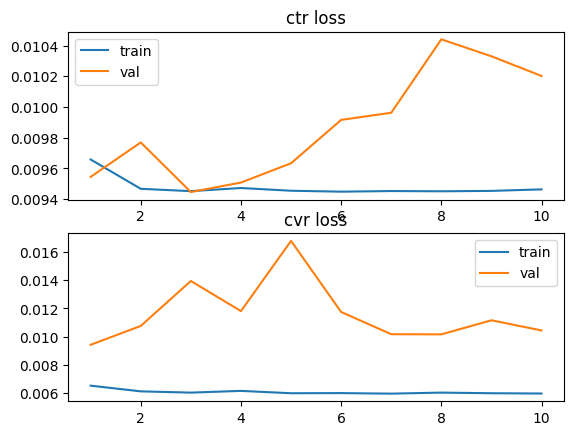

In [12]:
import matplotlib.pyplot as plt

x = [i for i in range(1, epochs+1)]

plt.subplot(2, 1, 1)
plt.plot(x, train_ctr_loss)
plt.plot(x, test_ctr_loss)
plt.legend(['train', 'val'])
plt.title("ctr loss")

plt.subplot(2, 1, 2)
plt.plot(x, train_ctcvr_loss)
plt.plot(x, test_ctcvr_loss)
plt.legend(['train', 'val'])
plt.title("cvr loss")

plt.show()

In [13]:
from sklearn.metrics import roc_auc_score

ctr_auc = 0.0
ctcvr_auc = 0.0
model.eval()
with torch.no_grad():
    for X, click, conversion in test_dataloader:
        X = X.to(device)
        click = click.unsqueeze_(-1).to(device)
        conversion = conversion.unsqueeze_(-1).to(device)

        p_ctr, p_ctcvr = model(X)

        ctr_auc += roc_auc_score(click, p_ctr)
        ctcvr_auc += roc_auc_score(conversion, p_ctcvr)

    print('ctr auc: {:.3f}'.format(ctr_auc/len(test_dataloader)))
    print('ctcvr auc: {:.3f}'.format(ctcvr_auc/len(test_dataloader)))

ctr auc: 0.659
ctcvr auc: 0.585


观察模型训练及验证的 loss 曲线，无明显下降。

在验证集上分别计算，点击的平均 AUC 为 0.659，转化的平均 AUC 为 0.585。

模型表现非常差，几乎学不到任何有效信息。

## 结论

现有特征主要为设备品牌区域信息和广告渠道大小类型等信息，缺少用户兴趣画像和广告内容画像，基于现有特征即使人类专家也很难判断点击情况，模型更难于学习设备和广告的匹配关系。

优化方向：
1. 特征方面：用户侧挖掘能描述用户兴趣的特征，广告侧增加基于广告内容的画像信息
2. 数据方面：增加数据量，考虑到新用户较多的冷启动问题，增加数据到 3 个月以上可能更好地描述用户特征
3. 模型方面：目前使用模型结构较为简单，未考虑用户和广告间的特征交叉

更精细的特征工程，加上更大量的数据，可以支持更复杂的模型学到更深层的隐含关系。